# **YouTube Sentiment Analysis**

In [144]:
from googleapiclient.discovery import build
import json
import requests
import time
import pandas as pd
import re
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

### Supressing all warnings

In [145]:
import warnings
warnings.filterwarnings('ignore')

## Extracting Comments From a YouTube video

### Taking input and Splitting the video Id

In [146]:
#Test url with emoji's https://www.youtube.com/watch?v=las-iT6Vp6g
#Test url with links https://www.youtube.com/watch?v=Ou3v8-ngN6Y
#Test url with punctuations https://www.youtube.com/watch?v=tktKJWdLv10
#Test with most comments https://www.youtube.com/watch?v=gdZLi9oWNZg
url_input = "https://www.youtube.com/watch?v=zKDfhGpRy3w"
video_id_split =url_input.split('=')
video_id=video_id_split[1]

### Total number of comments

#### *Quota impact: A call to this method has a quota cost of 1 unit.*
#### *1 call returns 20 comments* 
#### *Daily quota limit = 10,000 unit (Daily quotas reset at midnight Pacific Time (PT) = 12.45 PM NPT)* 
#### *Total number of comments that can be retrived in a day ~ 10,000 * 20 = 200,000* 
#### *Approximately < 195,000 comment's can be retrived in a day*


In [147]:
api_key = ''
url = 'https://www.googleapis.com/youtube/v3/videos?id='+video_id+'&key='+api_key+'&part=snippet,contentDetails,statistics,status'
response_info=requests.get(url).json()
comments=[]
for comment_count in response_info['items']:
 comments.append(comment_count['statistics'])
for val in comments:
  total = int(val['commentCount'])
print(total)
if(total>=195000):
  print("Cannot retrive more than 195,000 comments")

14262


### ***(Additional)*** For viewing the number of dislikes in the video

In [148]:
url_api = "https://returnyoutubedislikeapi.com/votes?videoId="+video_id
response_API=requests.get(url_api)
data = response_API.text
parse_json = json.loads(data)
number_dislikes = parse_json['dislikes']
print(number_dislikes)

2543


### Storing all the comments in a list


In [149]:
def getAllTopLevelCommentReplies(topCommentId, replies, token): 
    replies_response=youtube.comments().list(part='snippet',
                                               maxResults=100,
                                               parentId=topCommentId,
                                               pageToken=token).execute()

    for item in replies_response['items']:
        replies.append(item['snippet']['textDisplay'])
    if "nextPageToken" in replies_response: 
      return getAllTopLevelCommentReplies(topCommentId, replies, replies_response['nextPageToken'])
    else:
      return replies
      
def get_comments(youtube, video_id, comments=[], token=''):
  totalReplyCount = 0
  replies=[]

  video_response=youtube.commentThreads().list(part='snippet',
                                               videoId=video_id,
                                               pageToken=token).execute()
  for item in video_response['items']:
            comment = item['snippet']['topLevelComment']
            text = comment['snippet']['textDisplay']
            totalReplyCount = item['snippet']['totalReplyCount']
            if (totalReplyCount > 0): 
               comments.extend(getAllTopLevelCommentReplies(comment['id'], replies, None)) 
            else: 
               comments.append(text)
            replies = []

  if "nextPageToken" in video_response: 
        return get_comments(youtube, video_id, comments, video_response['nextPageToken'])
  else:
        return comments

youtube = build('youtube', 'v3',developerKey=api_key)
comments = get_comments(youtube,video_id)
print(len(comments))

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/__init__.py", line 44, in autodetect
    from . import file_cache
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 41, in <module>
    "file_cach

12688


### Converting the list to dataframe


In [150]:
df_from_yt = pd.DataFrame(comments,columns=['Comments'])
print(df_from_yt)

                                                Comments
0      Those are young criminals not young guys and w...
1      It is a shame that they lived to tell the tale...
2      Put all them lives in danger, and 100% guarant...
3                              He can drive thouth😂😂😂😂😂😂
4      they are not the first ants in the row i guess...
...                                                  ...
12683                                  Go back to school
12684                         yeah exactly ... long time
12685                                   @Cats Paw Lol😂🤣😂
12686                                      keep washing!
12687                                                1st

[12688 rows x 1 columns]


### Data Cleaning 
 

### Removing all the emoji's from the dataframe


In [152]:
df_from_yt = df_from_yt.astype(str).apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii'))
df_from_yt

,Comments
0,Those are young criminals not young guys and w...
1,It is a shame that they lived to tell the tale...
2,"Put all them lives in danger, and 100% guarant..."
3,He can drive thouth
4,they are not the first ants in the row i guess...
...,...
12683,Go back to school
12684,yeah exactly ... long time
12685,@Cats Paw Lol
12686,keep washing!


### Removing all the url's from the data frame

In [153]:
df_from_yt['Comments'] = df_from_yt['Comments'].apply(lambda x: re.split('<a href="https:\/\/.*', str(x))[0])
df_from_yt

,Comments
0,Those are young criminals not young guys and w...
1,It is a shame that they lived to tell the tale...
2,"Put all them lives in danger, and 100% guarant..."
3,He can drive thouth
4,they are not the first ants in the row i guess...
...,...
12683,Go back to school
12684,yeah exactly ... long time
12685,@Cats Paw Lol
12686,keep washing!


### Removing all special characters

In [154]:
def process_content(content):
    return " ".join(re.findall("[A-Za-z]+",content))

df_from_yt['Comments'] = df_from_yt['Comments'].apply(process_content)
df_from_yt

,Comments
0,Those are young criminals not young guys and w...
1,It is a shame that they lived to tell the tale...
2,Put all them lives in danger and guarantee wil...
3,He can drive thouth
4,they are not the first ants in the row i guess...
...,...
12683,Go back to school
12684,yeah exactly long time
12685,Cats Paw Lol
12686,keep washing


### Converting to lower case

In [155]:
df_from_yt['Comments'] = df_from_yt['Comments'].str.lower()
df_from_yt

,Comments
0,those are young criminals not young guys and w...
1,it is a shame that they lived to tell the tale...
2,put all them lives in danger and guarantee wil...
3,he can drive thouth
4,they are not the first ants in the row i guess...
...,...
12683,go back to school
12684,yeah exactly long time
12685,cats paw lol
12686,keep washing


### Removing empty rows

In [156]:
df_from_yt['Comments'].replace('', np.nan, inplace=True)
df_from_yt= df_from_yt.dropna()
df_from_yt

,Comments
0,those are young criminals not young guys and w...
1,it is a shame that they lived to tell the tale...
2,put all them lives in danger and guarantee wil...
3,he can drive thouth
4,they are not the first ants in the row i guess...
...,...
12683,go back to school
12684,yeah exactly long time
12685,cats paw lol
12686,keep washing


# **Training and Testing Model for Spam Detection**

### Importing dataset's and storing into a dataframe 

In [66]:
train_data=[]
data_files = ['/content/drive/MyDrive/Youtube-Sentiment-Analysis/Youtube01-Psy.csv',
              '/content/drive/MyDrive/Youtube-Sentiment-Analysis/Youtube02-KatyPerry.csv',
              '/content/drive/MyDrive/Youtube-Sentiment-Analysis/Youtube03-LMFAO.csv',
              '/content/drive/MyDrive/Youtube-Sentiment-Analysis/Youtube04-Eminem.csv',
              '/content/drive/MyDrive/Youtube-Sentiment-Analysis/Youtube05-Shakira.csv']
for file in data_files:
    data = pd.read_csv(file)
    train_data.append(data)
train_data = pd.concat(train_data)

In [67]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1956 entries, 0 to 369
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   COMMENT_ID  1956 non-null   object
 1   AUTHOR      1956 non-null   object
 2   DATE        1711 non-null   object
 3   CONTENT     1956 non-null   object
 4   CLASS       1956 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 91.7+ KB


## Data Cleaning

### Dropping the columns that isn't required

In [68]:
def drop_fectures(features,data):
    data.drop(features,axis=1,inplace=True)

drop_fectures(['COMMENT_ID','AUTHOR','DATE'],train_data)

### Removing all special characters

In [69]:
def process_content(content):
    return " ".join(re.findall("[A-Za-z]+",content.lower()))
  
train_data['CONTENT'] = train_data['CONTENT'].apply(process_content)
train_data

,CONTENT,CLASS
0,huh anyway check out this you tube channel kob...,1
1,hey guys check out my new channel and our firs...,1
2,just for test i have to say murdev com,1
3,me shaking my sexy ass on my channel enjoy,1
4,watch v vtarggvgtwq check this out,1
...,...,...
365,i love this song because we sing it at camp al...,0
366,i love this song for two reasons it is about a...,0
367,wow,0
368,shakira u are so wiredo,0


## Splitting data into *train* and *test* sets

In [70]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
                                    train_data['CONTENT'],
                                   train_data['CLASS'],
                                   test_size=0.2,
                                   random_state=57)

## Data Encoding

### Using [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) for converting  text to numerical data. 

In [71]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(stop_words='english')
x_train_counts = count_vect.fit_transform(x_train)
x_train_counts.shape

(1564, 3345)

### Using TfidfTransformer 
*Transform a count matrix to a normalized tf or tf-idf representation.*

*Tf means term-frequency while tf-idf means term-frequency times inverse document-frequency. This is a common term weighting scheme in information retrieval, that has also found good use in document classification.*

*The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.*

In [72]:
from sklearn.feature_extraction.text import TfidfTransformer
tranformer = TfidfTransformer()
x_train_tfidf = tranformer.fit_transform(x_train_counts)
x_train_tfidf.shape
x_test_counts = count_vect.transform(x_test)
x_test_tfidf = tranformer.transform(x_test_counts)

## Model Selection 


### Blank list for **Comparison**

In [73]:
Accuracy = []
Algorithm = []
from sklearn.metrics import accuracy_score

### Linear Regression

In [74]:
from sklearn.linear_model import LinearRegression
Algorithm.append('LinearRegression (ML)')
regressor = LinearRegression()
regressor.fit(x_train_tfidf, y_train)
predicted = regressor.predict(x_test_tfidf)

#### Calculating Accuracy

In [75]:
a = accuracy_score(y_test,predicted.round())*100
Accuracy.append("%.2f" % a)

### XGBoost or Extreme Gradient Boost Regression

In [76]:
import xgboost as xgb
Algorithm.append('XGB Regressor (ML)')
regressor = xgb.XGBRegressor()
regressor.fit(x_train_tfidf, y_train)
predicted = regressor.predict(x_test_tfidf)

[14:34:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


#### Accuracy


In [77]:
a = accuracy_score(y_test,predicted.round())*100
Accuracy.append("%.2f" % a)

###  Random Forest Regression

In [78]:
from sklearn.ensemble import RandomForestRegressor
Algorithm.append('RandomForestRegressor (ML)')
regressor = RandomForestRegressor() 
regressor.fit(x_train_tfidf, y_train)
predicted = regressor.predict(x_test_tfidf)

#### Accuracy

In [79]:
a = accuracy_score(y_test,predicted.round())*100
Accuracy.append("%.2f" % a)

### Keras **(Deep Learning)**

#### Importing

In [80]:
import tensorflow as tf
import tensorflow_hub as hub
import keras 

# helps in text preprocessing
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# helps in model building
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import EarlyStopping

#### Building the model

In [81]:
model = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)

model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 50)                48190600  
                                                                 
 dense_2 (Dense)             (None, 16)                816       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________
None


#### Training the model

In [82]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(x_train,
         y_train,
         epochs=40,
         batch_size=512,
         validation_data=(x_test, y_test),
         verbose=1,
         callbacks=[early_stop]
)

Epoch 1/40
4/4 [==============================] - 2s 339ms/step - loss: 0.6752 - accuracy: 0.6087 - val_loss: 0.6517 - val_accuracy: 0.6760
Epoch 2/40
4/4 [==============================] - 1s 259ms/step - loss: 0.6342 - accuracy: 0.7027 - val_loss: 0.6265 - val_accuracy: 0.7321
Epoch 3/40
4/4 [==============================] - 1s 265ms/step - loss: 0.6044 - accuracy: 0.7864 - val_loss: 0.6028 - val_accuracy: 0.7551
Epoch 4/40
4/4 [==============================] - 1s 265ms/step - loss: 0.5769 - accuracy: 0.8127 - val_loss: 0.5789 - val_accuracy: 0.7679
Epoch 5/40
4/4 [==============================] - 1s 255ms/step - loss: 0.5497 - accuracy: 0.8350 - val_loss: 0.5587 - val_accuracy: 0.8087
Epoch 6/40
4/4 [==============================] - 1s 266ms/step - loss: 0.5240 - accuracy: 0.8715 - val_loss: 0.5389 - val_accuracy: 0.8597
Epoch 7/40
4/4 [==============================] - 1s 264ms/step - loss: 0.4982 - accuracy: 0.9118 - val_loss: 0.5154 - val_accuracy: 0.8648
Epoch 8/40
4/4 [====

#### Testing the model

In [83]:
predicted = model.predict(x_test)

Algorithm.append('Keras (DL)')

#### Accuracy

In [84]:
a = accuracy_score(y_test,predicted.round())*100
Accuracy.append("%.2f" % a)

## Creating a comparison dataframe


In [85]:
comparison = pd.DataFrame(list(zip(Algorithm, Accuracy)), columns = ['Algorithm', 'Accuracy'])
comparison

,Algorithm,Accuracy
0,LinearRegression (ML),86.99
1,XGB Regressor (ML),90.82
2,RandomForestRegressor (ML),94.39
3,Keras (DL),91.33


## Choosing the best model

In [86]:
from sklearn.ensemble import RandomForestRegressor
Algorithm.append('RandomForestRegressor (ML)')
regressor_final = RandomForestRegressor() 
regressor_final.fit(x_train_tfidf, y_train)
predicted_final = regressor_final.predict(x_test_tfidf)

### Data Encoding

#### Using CountVectorizer

In [142]:
# from sklearn.feature_extraction.text import CountVectorizer
# count_vect = CountVectorizer(stop_words='english')
# df_from_yt = count_vect.fit_transform(df_from_yt)
# df_from_yt.shape

(1, 1)

#### Using TfidfTransformer

In [88]:
# from sklearn.feature_extraction.text import TfidfTransformer
# tranformer = TfidfTransformer()
# df_from_yt_final_tfidf = tranformer.fit_transform(df_from_yt_count)
# df_from_yt_final_tfidf.shape

# **Creating Model for Categorizing Positive/Negative Comments**

## **Natural Language Processing (NLP)**

In [157]:
from textblob import TextBlob
TextBlob('<3').sentiment.polarity

1.0

### Creating a list that will contain polarity of the Comments

In [160]:
polarity=[] 

for i in df_from_yt['Comments']:
    if(isinstance(i,float)):
      pass
    else:
      polarity.append(TextBlob(i).sentiment.polarity)

df_from_yt['polarity']=polarity
df_from_yt

,Comments,polarity
0,those are young criminals not young guys and w...,0.2875
1,it is a shame that they lived to tell the tale...,0.5000
2,put all them lives in danger and guarantee wil...,0.0000
3,he can drive thouth,0.0000
4,they are not the first ants in the row i guess...,0.2500
...,...,...
12683,go back to school,0.0000
12684,yeah exactly long time,-0.0500
12685,cats paw lol,0.8000
12686,keep washing,0.0000


## EDA for positive comments

In [168]:
comments_positive=df_from_yt.loc[(df_from_yt['polarity']>=0.5) & (df_from_yt['polarity']<=1)]
comments_positive.head

<bound method NDFrame.head of                                                 Comments  polarity
1      it is a shame that they lived to tell the tale...      0.50
36                                      many eyes to him      0.50
37                           what they had some weed lol      0.80
46                 wow very good job guys perfect timing      0.67
47                                               lol omg      0.80
...                                                  ...       ...
12649  wouldve never even guessed the aspiring colleg...      0.80
12668                             good job by the police      0.70
12678  r wallstreetsilver oh yea for sure i meant one...      0.65
12682                           washed ok yolanda lmmfao      0.50
12685                                       cats paw lol      0.80

[1407 rows x 2 columns]>

#### *Word Cloud is a data visualization technique used for representing text data in which the size of each word indicates its frequency or importance*

In [163]:
from wordcloud import WordCloud,STOPWORDS

stopwords=set(STOPWORDS)

In [164]:
total_comments=' '.join(comments_positive['Comments'])

In [165]:
wordcloud=WordCloud(width=1000,height=500,stopwords=stopwords).generate(total_comments)

(-0.5, 999.5, 499.5, -0.5)

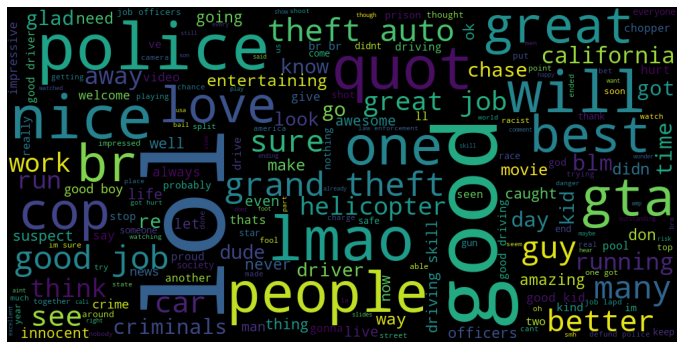

In [166]:
plt.figure(figsize=(12,8))
plt.imshow(wordcloud)
plt.axis('off')

## EDA for negative comments

In [182]:
comments_negative=df_from_yt.loc[(df_from_yt['polarity']<=-0.25)]

comments_negative.head

<bound method NDFrame.head of                                                 Comments  polarity
7                                         ahahahah crazy -0.600000
13                                 smh kids are so crazy -0.600000
75                                        usual suspects -0.250000
77                      it did end bad they got arrested -0.700000
79     you made the cops chase you and then chase you... -0.300000
...                                                  ...       ...
12592  i know its so shocking every time the commerci... -0.266667
12601                        like you bad jog on jogglet -0.700000
12643  anytime you see stupid or brazen crimes like t... -0.425000
12660  i know they will but that doesn t mean that wh... -0.302083
12681  hero gaming that s not fair he didn t get his ... -0.350000

[1245 rows x 2 columns]>

In [183]:
total_comments=' '.join(comments_negative['Comments'])

In [184]:
wordcloud=WordCloud(width=1000,height=500,stopwords=stopwords).generate(total_comments)

(-0.5, 999.5, 499.5, -0.5)

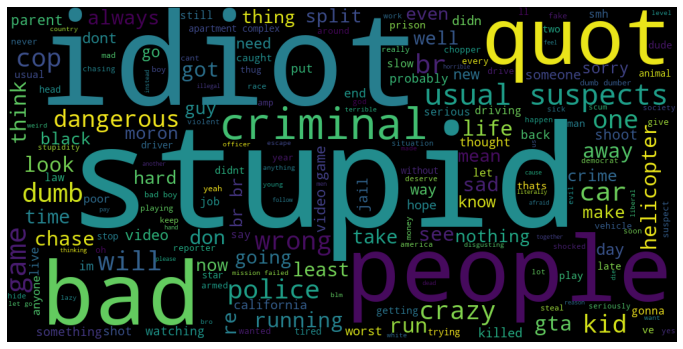

In [185]:
plt.figure(figsize=(12,8))
plt.imshow(wordcloud)
plt.axis('off')

## EDA For neutral comments

In [187]:
comments_neutral=df_from_yt.loc[(df_from_yt['polarity']<0.5) & (df_from_yt['polarity']>-0.25)]

comments_neutral.head

<bound method NDFrame.head of                                                 Comments  polarity
0      those are young criminals not young guys and w...  0.287500
2      put all them lives in danger and guarantee wil...  0.000000
3                                    he can drive thouth  0.000000
4      they are not the first ants in the row i guess...  0.250000
5      this is what comes from when states that are s... -0.083333
...                                                  ...       ...
12680                       teber peterie thanks watched  0.200000
12683                                  go back to school  0.000000
12684                             yeah exactly long time -0.050000
12686                                       keep washing  0.000000
12687                                                 st  0.000000

[9703 rows x 2 columns]>

In [188]:
total_comments=' '.join(comments_neutral['Comments'])

In [189]:
wordcloud=WordCloud(width=1000,height=500,stopwords=stopwords).generate(total_comments)

(-0.5, 999.5, 499.5, -0.5)

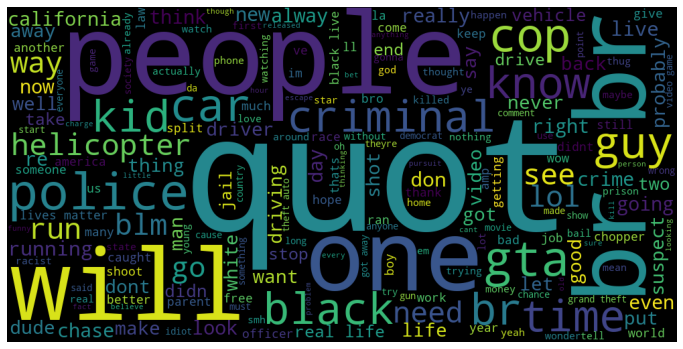

In [190]:
plt.figure(figsize=(12,8))
plt.imshow(wordcloud)
plt.axis('off')

In [218]:
total_comments_yt = int(df_from_yt.shape[0])

def calculate_percentage(x):

  return round((100.0 * x / total_comments_yt),2)

total_neutral = int(comments_neutral.shape[0])
total_positive = int(comments_positive.shape[0])
total_negative = int(comments_negative.shape[0])


total_positive_per = calculate_percentage(total_positive)
total_negative_per = calculate_percentage(total_negative)
total_neutral_per = calculate_percentage(total_neutral)

print(total_positive_per,'%')
print(total_negative_per,'%')
print(total_neutral_per ,'%')
 

11.39 %
10.08 %
78.54 %
